In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from evaluation import get_util
from model_utils import *

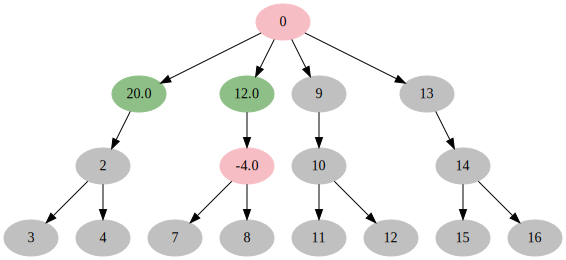

In [3]:
# Need the `dot` command from graphviz to visualize tree with `env.render()`
# -> install graphviz by running BOTH commands below:
# conda install graphviz
# pip install graphviz

import os
os.environ['PATH'] +=':/home/fredcallaway/miniconda3/envs/mcrl/bin/'

env = make_env(1.25)
env.reset()
for a in [1, 5, 6,]:
    env.step(a)
env.render()

# Linear softmax policy

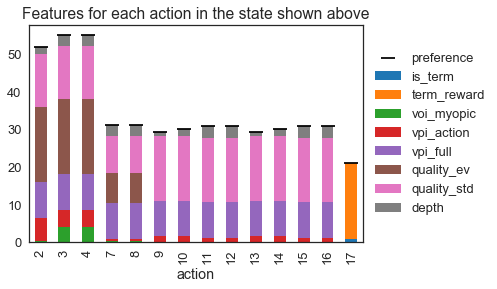

In [4]:
from mouselab_policy import MouselabPolicy

agent = Agent()
theta = np.ones(8)
weights = {
    'is_term': 1,
    'term_reward': 1,
    'voi_myopic': 1,
    'vpi_action': 1,
    'vpi_full': 1,
    'quality_ev': 1,
    'quality_std': 1,
    'depth': 1,
}
pol = MouselabPolicy(weights, temp=1)
agent.register(env)
agent.register(pol)
features = list(pol.weights.keys())

actions = list(env.actions(env._state))
phi = [pol.phi(env._state, action)[:-1]  # leave out dummy coefficient
       for action in actions]

phi = pd.DataFrame(phi, index=actions, columns=weights.keys())
phi.plot.bar(stacked=True, legend=False)
plt.scatter(range(len(phi)), phi.sum(1), 
            c='k', marker='_', s=200, zorder=10, label='preference')
plt.axhline(0, c='k', lw=1)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xlabel('action')
plt.title('Features for each action in the state shown above')

# Simulate experiment

In [4]:
import json
from analysis_utils import *
from agents import run_episode
df, pdf = load('1.8', base='exp-data')
COSTS = pdf.info_cost.unique()
env = None
# Load the reward structures used in the experiment.
def exp_envs():
    global env
    for cost in pdf.info_cost.unique():
        with open(f'exp-data/rewards_{cost:.2f}.json') as f:
            d = json.load(f)
            for kind in 'train', 'test':
                for t in d[kind]:
                    env = make_env(cost, t['stateRewards'])
                    trace = run_episode(read_bo_policy(cost), env)
                    yield {'cost': cost, 'trial_id': t['trial_id'], 'kind': kind, 'env': env,
                           'optimal_clicks': len(trace['actions']) - 1, 
                           'optimal_return': trace['return']}

exp_envs = pd.DataFrame(exp_envs())
exp_envs.drop('env', axis=1).set_index('trial_id').to_csv('data/exp_envs.csv')
exp_envs.groupby(['kind', 'cost']).optimal_return.mean()

kind   cost
test   0.10    17.616667
       1.25    17.208333
       4.00     3.000000
train  0.10    16.540000
       1.25     4.775000
       4.00     1.200000
Name: optimal_return, dtype: float64

In [5]:
from agents import run_episode
from utils import Labeler
from toolz.curried import *
label = Labeler()
def simulate(policy, envs, seed=None):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for trial_id, env in envs.items():
        trace = run_episode(policy, env)
        for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
            yield {'pid': seed, 'cost': abs(env.cost), 'trial_id': trial_id,
                   'state': label(s), 'action': a, 'reward': r}
        
pol = MouselabPolicy({
    'is_term': 3,
    'term_reward': 0,
    'voi_myopic': 1,
    'vpi_action': 0,
    'vpi_full': 0,
    'quality_ev': .2,
    'quality_std': .1,
    'depth': 0,
})
alt_envs = {i: make_env(1.25) for i in range(100)}
data = pd.DataFrame(simulate(pol, alt_envs))

30    15
2     14
63    14
72    14
49    13
22    13
15    13
81    12
44    12
80    12
87    12
98    11
47    11
43    11
54    11
93    11
26    11
70    10
37    10
50    10
20    10
90    10
83    10
73    10
5     10
34    10
55    10
7     10
38     9
4      9
      ..
79     6
71     6
68     6
46     6
61     6
48     6
18     6
58     6
53     6
1      5
8      5
99     5
19     5
29     5
97     5
96     5
95     5
82     5
78     5
77     5
76     5
75     5
69     5
66     5
64     5
56     5
42     5
0      5
45     4
40     4
Name: trial_id, Length: 100, dtype: int64

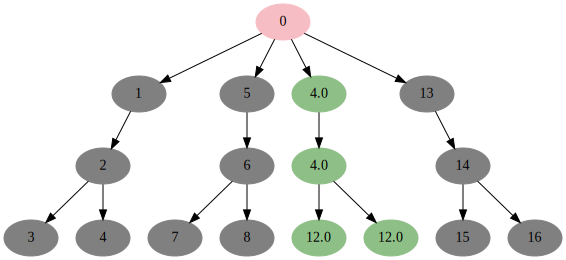

In [6]:
def expand(i, level=0):
    s = '?' if hasattr(state[i], 'sample') else state[i]
    print(level * ' ', s)
    for k in env.tree[i]:
        expand(k, level+1)
        
from IPython.display import clear_output, display
from time import sleep
from shutil import rmtree
trace = run_episode(pol, env)
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        rmtree('trace/', ignore_errors=True)
        clear_output()
        env._state = s
        dot = env.render()
        display(dot)
#         dot.view(filename=f'{i}', directory='trace', cleanup=True)
        sleep(1)
        
render(trace)

# Fit human data

In [160]:
from analysis_utils import load
from utils import Labeler
from model_utils import *
from toolz import *
df, pdf = load('1.7', base='../experiments/data/human')
df.pid = df.pid.apply(Labeler())
label = Labeler()
def expand(df):
    for i, row in df.iterrows():
        for s, a in zip(row.states, concatv(row.clicks, [ENV.term_action])):
            yield {'pid': row.pidx, 'cost': row.info_cost, 'pr_type': row.pr_type,
                   'state': label(parse_state(s)), 'action': a, 'trial_id': row.trial_id}

data = pd.DataFrame(expand(df.query('pid < 5')))
data.head()

,action,cost,pid,pr_type,state,trial_id
0,13,0.1,0,none,0,4
1,16,0.1,0,none,1,4
2,14,0.1,0,none,2,4
3,5,0.1,0,none,3,4
4,6,0.1,0,none,4,4


Likelihood:
$$p(D \mid \theta) = \prod_i^N p(a_i \mid s_i; \theta)$$

Softmax Q policy:
$$p(a \mid s; \theta) = \frac{\exp \{ Q(s, a; \theta) \} }{ \sum_{a'} \exp \{ Q(s, a'; \theta) \} }$$

Linear regression Q:
$$Q(s, a; \theta) = \theta^\top \phi(s, a)$$

Before performing inference, we precompute the features, storing them in a 3d tensor.
`phi[s, a, f]` will give the value $\phi(s, a)_f$


In [6]:
phi = np.array([[pol.phi(s, a) for a in range(env.term_action + 1)]
                 for s in label._xs])

In [ ]:
phi2 = phi.copy()
phi2[:, :, :8] -= phi[:, :, :8].mean(0)
phi2[:, :, :8] /= (phi[:, :, :8].std(0) + 1e-100)

In [7]:
def logp(data, theta, temp=1):
    Q = np.dot(phi[data.state.as_matrix()], theta)
    Q -= Q.max(1).reshape(-1, 1)  # prevent float overflow 
    idx = np.arange(len(data))
    eq = np.exp(Q / temp)
    chosen = eq[idx, data.action.as_matrix()]
    return np.log(chosen / eq.sum(1))
    
print('Predictive accuracy')
print('  true policy:', np.exp(logp(data, pol.theta, 1e-10).sum() / len(data)))
print('  random policy:', np.exp(logp(data, np.zeros_like(pol.theta), 1).sum() / len(data)))

Predictive accuracy
  true policy: 0.332164126488
  random policy: 0.0555555555556


In [118]:
import pymc3 as pm
import theano.tensor as tt

def run_model(data):
    n_data = len(data)
    pid = data.pid.as_matrix()
    n_pid = pid.max() + 1
    print(f'{n_pid} participants')
    idx = np.arange(len(data))
    state = data.state.as_matrix()
    action = data.action.as_matrix()
    # std = dict(zip(features, phi[state].std((0,1))))
    

    with pm.Model() as model:
        temp = pm.Exponential('temp',1, shape=n_pid)
    
        theta = pm.Normal('theta', 0, 1, shape=(n_pid, 8))
        norm = ((theta ** 2).sum(1) ** 0.5)
        norm = norm.reshape((n_pid, 1))
        
        # Normalize and add dummy coef.
        theta = tt.concatenate([theta / norm, tt.ones((n_pid, 1))], axis=1)
        preference = tt.dot(phi2, theta.T)[state, :, pid]
        preference -= preference.max(1).reshape((n_data, 1))  # numerical stability
        epref = tt.exp(preference / temp[pid].reshape((n_data, 1)))
        chosen = epref[idx, action]
        
        logp = pm.Deterministic('log_likelihood', tt.log(chosen / epref.sum(1)))
        pm.Potential('', logp.sum())
#         pm.Potential('normalizer', - 100 * abs(norm - 1))

        return pm.sample(njobs=2), model

trace, model = run_model(data)

n_pid 5


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
[2018-01-07 15:46:11,070] install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 1000/1000 [01:32<00:00, 10.83it/s]


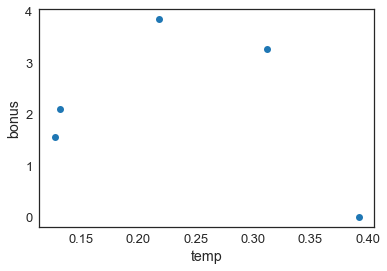

In [142]:
plt.plot(trace['temp'].mean(0), pdf.loc[:4].bonus, 'o')
plt.xlabel('temp')
plt.ylabel('bonus')

In [119]:
idx = pd.MultiIndex.from_product([
     range(trace['theta'].shape[0]),
     range(trace['theta'].shape[1]),
     weights.keys(),
 ], names=['sample', 'pid', 'feature'])
tdf = pd.Series(trace['theta'].ravel(), index=idx)
tdf = tdf.reset_index().rename(columns={0: 'value'})

In [162]:
grp.ngroups

463

In [167]:
axes

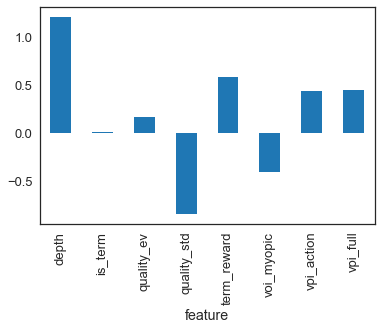

In [187]:
x = tdf.groupby('feature').value.mean()
x.plot.bar(color=sns.color_palette())

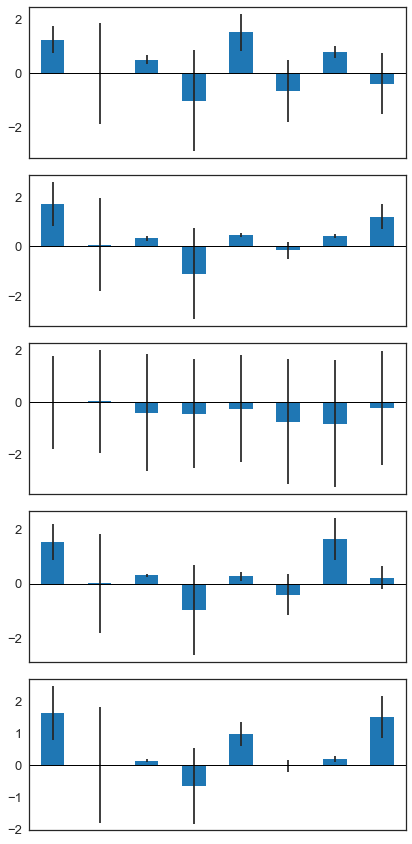

In [192]:
def plot_weights(data):
    
    grp = data.groupby('feature').value
    yerr = np.stack(grp.apply(lambda x: pm.hpd(x)))
    grp.mean().plot.bar(yerr=yerr.T)
    plt.xticks([])
    plt.xlabel('')
    plt.axhline(0, c='k', lw=1)


grp = tdf.groupby('pid')
fig, axes = plt.subplots(grp.ngroups, squeeze=0, figsize=(6, 12))
axes = iter(axes.flat)
for pid, dd in grp:
    plt.sca(next(axes))
    plot_weights(dd)

plt.tight_layout()


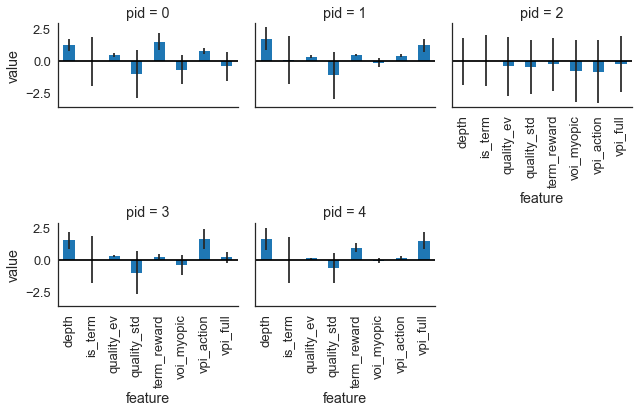

In [121]:
g = sns.FacetGrid(tdf, col='pid', col_wrap=3)
def plot_weights(x, y, data, **kwargs):
    grp = data.groupby(x)[y]
    yerr = np.stack(grp.apply(lambda x: pm.hpd(x)))
    grp.mean().plot.bar(yerr=yerr.T)
    plt.axhline(0, c='k')
#     y1, y2 = pm.hpd(y)
#     print(y1, y2)

g.map_dataframe(plot_weights, 'feature', 'value')

In [122]:
theta = pd.DataFrame(trace['theta'], columns=features).apply(
        lambda row: row / np.linalg.norm(row),
    axis=1)

ValueError: Must pass 2-d input

In [30]:
true = pol.theta[:-1]
true = dict(zip(pol.weights.keys(), true / np.linalg.norm(true)))

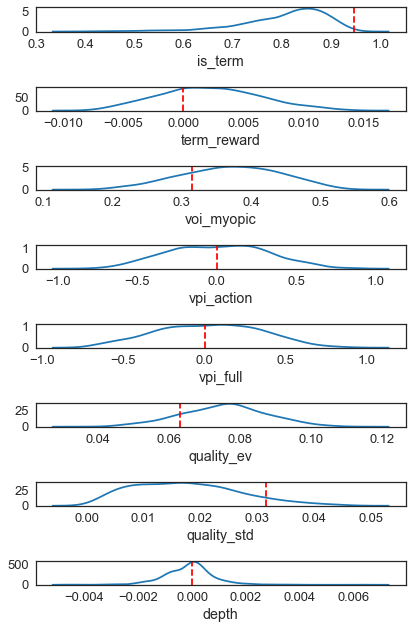

In [32]:
fig, axes = plt.subplots(len(theta.columns), figsize=(6, 9))
for k, ax in zip(theta, axes):
    plt.sca(ax)
    sns.distplot(theta[k], hist=0)
    plt.axvline(true[k], c='r', ls='--')

plt.tight_layout()
plt.show()

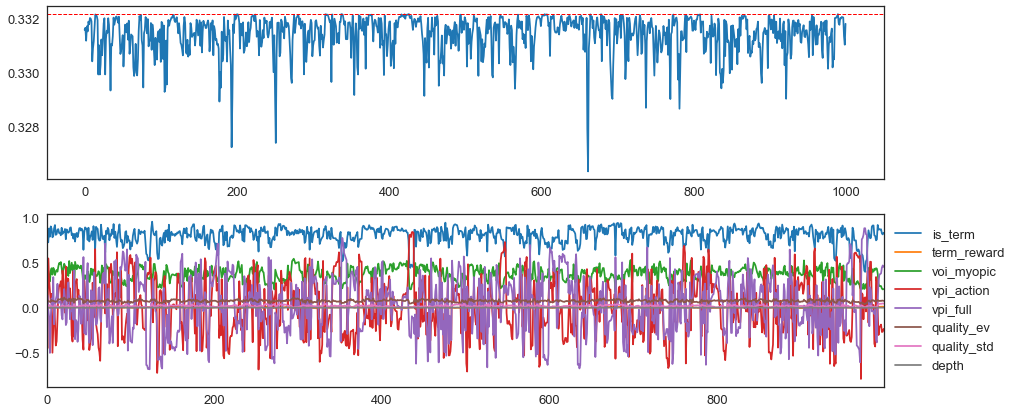

In [35]:
fig, ax = plt.subplots(2, figsize=(15,7))

plt.sca(ax[0])
plt.plot(np.exp(trace['log_likelihood'].mean(1)))
plt.axhline(np.exp(logp(data, pol.theta, temp=1e-9).mean()),
            c='r', ls='--', lw=1)

theta.plot(legend=False, ax=ax[1])
plt.sca(ax[1])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.ylim(-1, 10)
plt.savefig('fig.pdf')

Text(0.5,1,'Correlations in θ samples')

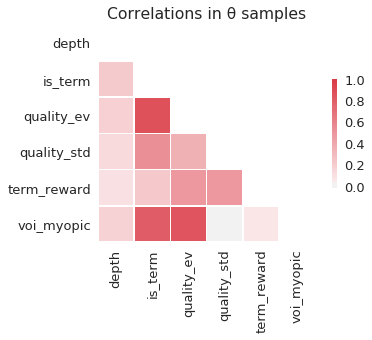

In [51]:
corr = theta.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations in θ samples')